# Download [zip_code_market_tracker.tsv000](https://www.kaggle.com/datasets/thuynyle/redfin-housing-market-data?select=zip_code_market_tracker.tsv000)

In [17]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io

In [18]:
!awk -F'\t' 'BEGIN {OFS="\t"} {NF=58; print}' zip_code_market_tracker.tsv000 > cleaned_data.tsv

In [19]:
charlotte_df = pl.scan_csv("cleaned_data.tsv", separator="\t").filter(
    (pl.col("parent_metro_region")  == 'Charlotte, NC') & 
    (pl.col("property_type") == 'All Residential'))

In [20]:
# Select final features
features_to_keep = [
    # Identifiers
    'period_begin', 'period_end', 'region', 'state_code',
    
    # Target
    'median_sale_price',
    
    # Core features (Tier 1)
    'median_list_price', 'median_ppsf',
    'homes_sold', 'inventory', 'new_listings', 'months_of_supply',
    'median_dom', 'pending_sales',
    'avg_sale_to_list', 'sold_above_list',
    'price_drops', 'off_market_in_two_weeks',
    
    # Pre-calculated trends (Tier 1)
    'median_sale_price_mom', 'median_sale_price_yoy',
    'months_of_supply_mom', 'months_of_supply_yoy',
    
    # Additional momentum (Tier 2)
    'homes_sold_mom', 'homes_sold_yoy',
    'inventory_mom', 'inventory_yoy',
    'median_dom_mom', 'median_dom_yoy',
    'price_drops_mom', 'price_drops_yoy',
    'pending_sales_mom', 'pending_sales_yoy',
    'new_listings_mom', 'new_listings_yoy',
]

# Filter and select
charlotte_clean = charlotte_df.select(features_to_keep)
# clean region zip code format
charlotte_clean = charlotte_clean.with_columns(
    pl.col("region").str.replace_all("Zip Code: ", "")
)

In [21]:
# Save
charlotte_clean = charlotte_clean.collect()
charlotte_clean.write_csv("charlotte_cleaned_data.csv")

In [22]:
!rm cleaned_data.tsv

In [23]:
charlotte_clean.head(10)

period_begin,period_end,region,state_code,median_sale_price,median_list_price,median_ppsf,homes_sold,inventory,new_listings,months_of_supply,median_dom,pending_sales,avg_sale_to_list,sold_above_list,price_drops,off_market_in_two_weeks,median_sale_price_mom,median_sale_price_yoy,months_of_supply_mom,months_of_supply_yoy,homes_sold_mom,homes_sold_yoy,inventory_mom,inventory_yoy,median_dom_mom,median_dom_yoy,price_drops_mom,price_drops_yoy,pending_sales_mom,pending_sales_yoy,new_listings_mom,new_listings_yoy
str,str,str,str,f64,f64,f64,i64,i64,i64,str,f64,i64,f64,f64,str,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""2015-12-01""","""2016-02-29""","""29706""","""SC""",111000.0,82500.0,66.41572,6,29,20,null,67.5,null,1.006592,0.166667,null,0.0,-0.647619,1.773267,null,null,1.0,0.0,0.035714,0.611111,-47.5,-278.5,null,null,null,null,0.176471,0.666667
"""2013-02-01""","""2013-04-30""","""28625""","""NC""",125500.0,139900.0,69.139194,75,274,141,null,132.5,null,0.931266,0.16,null,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""2021-04-01""","""2021-06-30""","""28281""","""NC""",1.0975e6,340000.0,479.339833,2,5,3,null,184.5,null,0.933881,0.0,null,1.0,0.0,2.276119,null,null,0.0,-0.6,-0.166667,0.666667,0.0,128.5,null,null,null,null,0.0,0.5
"""2021-01-01""","""2021-03-31""","""28081""","""NC""",240000.0,225000.0,135.663294,110,53,125,null,38.0,null,0.993465,0.336364,null,0.457143,0.014799,0.352113,null,null,-0.051724,0.170213,0.06,-0.417582,-9.0,-28.0,null,null,null,null,0.22549,0.0
"""2019-04-01""","""2019-06-30""","""28117""","""NC""",373500.0,386255.0,136.935276,382,496,430,null,77.0,null,0.976071,0.109948,null,0.197183,0.071736,-0.03861,null,null,0.026882,0.02965,0.066667,-0.07635,-4.0,9.0,null,null,null,null,0.007026,-0.122449
"""2018-12-01""","""2019-02-28""","""28079""","""NC""",269000.0,292700.0,120.096077,137,155,168,null,63.0,null,0.987213,0.175182,null,0.289474,0.035811,0.093496,null,null,-0.061644,0.045802,0.115108,0.230159,17.0,0.0,null,null,null,null,0.112583,0.244444
"""2021-07-01""","""2021-09-30""","""29710""","""SC""",380000.0,389900.0,163.94498,349,155,255,null,36.0,null,1.00581,0.43553,null,0.414286,0.013786,0.086025,null,null,-0.002857,0.191126,-0.066265,-0.301802,-0.5,-20.0,null,null,null,null,-0.059041,-0.229607
"""2016-01-01""","""2016-03-31""","""29732""","""SC""",167094.0,175000.0,93.216962,208,292,268,null,70.5,null,0.970848,0.182692,null,0.018868,0.012691,0.055886,null,null,0.130435,0.061224,0.073529,-0.153623,-13.0,-21.0,null,null,null,null,0.282297,0.015152
"""2018-04-01""","""2018-06-30""","""28034""","""NC""",185000.0,169950.0,86.952039,89,55,66,null,71.5,null,0.990276,0.269663,null,0.083333,-0.008256,0.090384,null,null,0.141026,0.618182,-0.246575,-0.112903,-54.5,-42.5,null,null,null,null,-0.029412,0.118644


shape: (33, 3)
┌──────────────────────────────┬───────────────┬─────────────┐
│ column                       ┆ missing_count ┆ missing_pct │
│ ---                          ┆ ---           ┆ ---         │
│ str                          ┆ u32           ┆ f64         │
╞══════════════════════════════╪═══════════════╪═════════════╡
│ months_of_supply_missing     ┆ 11765         ┆ 100.0       │
│ pending_sales_missing        ┆ 11765         ┆ 100.0       │
│ price_drops_missing          ┆ 11765         ┆ 100.0       │
│ months_of_supply_mom_missing ┆ 11765         ┆ 100.0       │
│ months_of_supply_yoy_missing ┆ 11765         ┆ 100.0       │
│ …                            ┆ …             ┆ …           │
│ state_code_missing           ┆ 0             ┆ 0.0         │
│ median_sale_price_missing    ┆ 0             ┆ 0.0         │
│ median_ppsf_missing          ┆ 0             ┆ 0.0         │
│ homes_sold_missing           ┆ 0             ┆ 0.0         │
│ sold_above_list_missing      ┆ 0      

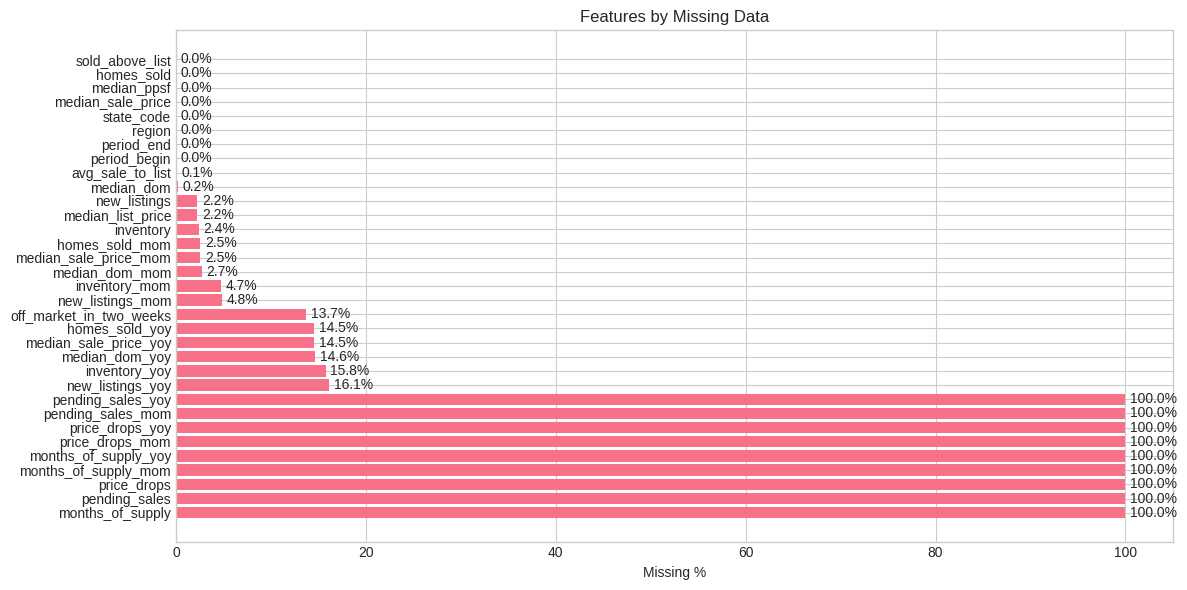

Zips with FULL coverage (30+ quarters): 113 - suitable for LSTM
Zips with PARTIAL coverage (15-29 quarters): 8
Zips with LIMITED coverage (<15 quarters): 10


In [24]:
df = pl.read_csv('charlotte_cleaned_data.csv')

# ========== MISSING DATA BY FEATURE ==========
missing_df = df.select([
    pl.all().null_count().name.suffix('_missing')
]).transpose(include_header=True, column_names=['missing_count'])
missing_df = missing_df.with_columns([
    (pl.col('missing_count') / len(df) * 100).alias('missing_pct')
]).sort('missing_pct', descending=True)
print(missing_df)

# Plot missing data
fig, ax = plt.subplots(figsize=(12, 6))
missing_pct = [(col, df[col].null_count() / len(df) * 100) for col in df.columns]
missing_pct = sorted(missing_pct, key=lambda x: x[1], reverse=True)
ax.barh([x[0] for x in missing_pct], [x[1] for x in missing_pct])
for i, (col, pct) in enumerate(missing_pct):
    ax.text(pct + 0.5, i, f"{pct:.1f}%", va='center')
ax.set_xlabel('Missing %')
ax.set_title('Features by Missing Data')
plt.tight_layout()
plt.show()


# ========== TIME COVERAGE ANALYSIS ==========
time_coverage = df.group_by('region').agg([
    pl.len().alias('quarters'),
    pl.col('period_begin').min().alias('first_quarter'),
    pl.col('period_begin').max().alias('last_quarter'),
    pl.col('median_sale_price').null_count().alias('missing_prices')
]).sort('quarters', descending=True)

print(f"Zips with FULL coverage (30+ quarters): {len(time_coverage.filter(pl.col('quarters') >= 30))} - suitable for LSTM")
print(f"Zips with PARTIAL coverage (15-29 quarters): {len(time_coverage.filter((pl.col('quarters') >= 15) & (pl.col('quarters') < 30)))}")
print(f"Zips with LIMITED coverage (<15 quarters): {len(time_coverage.filter(pl.col('quarters') < 15))}")

complete_zips = time_coverage.filter(pl.col('quarters') >= 30)['region'].to_list()

In [25]:
df = pl.read_csv('charlotte_cleaned_data.csv')

# ========== STEP 1: DROP EMPTY COLUMNS ==========
empty_columns = [
    'months_of_supply', 'pending_sales', 'price_drops',
    'months_of_supply_mom', 'months_of_supply_yoy',
    'price_drops_mom', 'price_drops_yoy',
    'pending_sales_mom', 'pending_sales_yoy',
]
df = df.drop(empty_columns)

# ========== STEP 2: FILL YoY WITH 0 ==========
yoy_columns = [
    'median_sale_price_yoy', 'homes_sold_yoy', 'inventory_yoy',
    'median_dom_yoy', 'new_listings_yoy',
]
for col in yoy_columns:
    df = df.with_columns(pl.col(col).fill_null(0))

# ========== STEP 3: FILL off_market_in_two_weeks ==========
median_omtw = df['off_market_in_two_weeks'].median()
df = df.with_columns(pl.col('off_market_in_two_weeks').fill_null(median_omtw))

# ========== STEP 4: FORWARD FILL + MEDIAN FOR SMALL GAPS ==========
small_missing = [
    'new_listings', 'median_list_price', 'inventory',
    'homes_sold_mom', 'median_sale_price_mom', 'median_dom_mom',
    'inventory_mom', 'new_listings_mom',
]

df = df.sort(['region', 'period_begin'])

for col in small_missing:
    df = df.with_columns(pl.col(col).forward_fill().over('region'))
    df = df.with_columns(pl.col(col).backward_fill().over('region'))
    df = df.with_columns(pl.col(col).fill_null(pl.col(col).median()))

# ========== STEP 5: FILL FINAL REMAINING ==========
df = df.with_columns([
    pl.col('median_dom').fill_null(pl.col('median_dom').median()),
    pl.col('avg_sale_to_list').fill_null(pl.col('avg_sale_to_list').median()),
])

# ========== STEP 6: ADD QUARTER METRIC ==========
# Extract quarter from period_begin date (format: YYYY-MM-DD)
df = df.with_columns([
    pl.col('period_begin').str.strptime(pl.Date, '%Y-%m-%d').dt.quarter().alias('quarter')
])

# ========== STEP 7: VERIFY ==========
total_missing = df.select([pl.all().null_count()]).sum_horizontal()[0]
print(f"\n✅ Total missing values: {total_missing}")

# ========== SAVE ==========
df.write_csv('charlotte_final_clean.csv')



✅ Total missing values: 0


In [26]:
# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
df_pd = pd.read_csv('charlotte_final_clean.csv')

In [27]:
# Verify quarter column was added
print(f"Columns in dataset: {df_pd.columns.tolist()}")
print(f"\nQuarter distribution:")
print(df_pd['quarter'].value_counts().sort_index())

Columns in dataset: ['period_begin', 'period_end', 'region', 'state_code', 'median_sale_price', 'median_list_price', 'median_ppsf', 'homes_sold', 'inventory', 'new_listings', 'median_dom', 'avg_sale_to_list', 'sold_above_list', 'off_market_in_two_weeks', 'median_sale_price_mom', 'median_sale_price_yoy', 'homes_sold_mom', 'homes_sold_yoy', 'inventory_mom', 'inventory_yoy', 'median_dom_mom', 'median_dom_yoy', 'new_listings_mom', 'new_listings_yoy', 'quarter']

Quarter distribution:
quarter
1    2894
2    3053
3    3029
4    2789
Name: count, dtype: int64


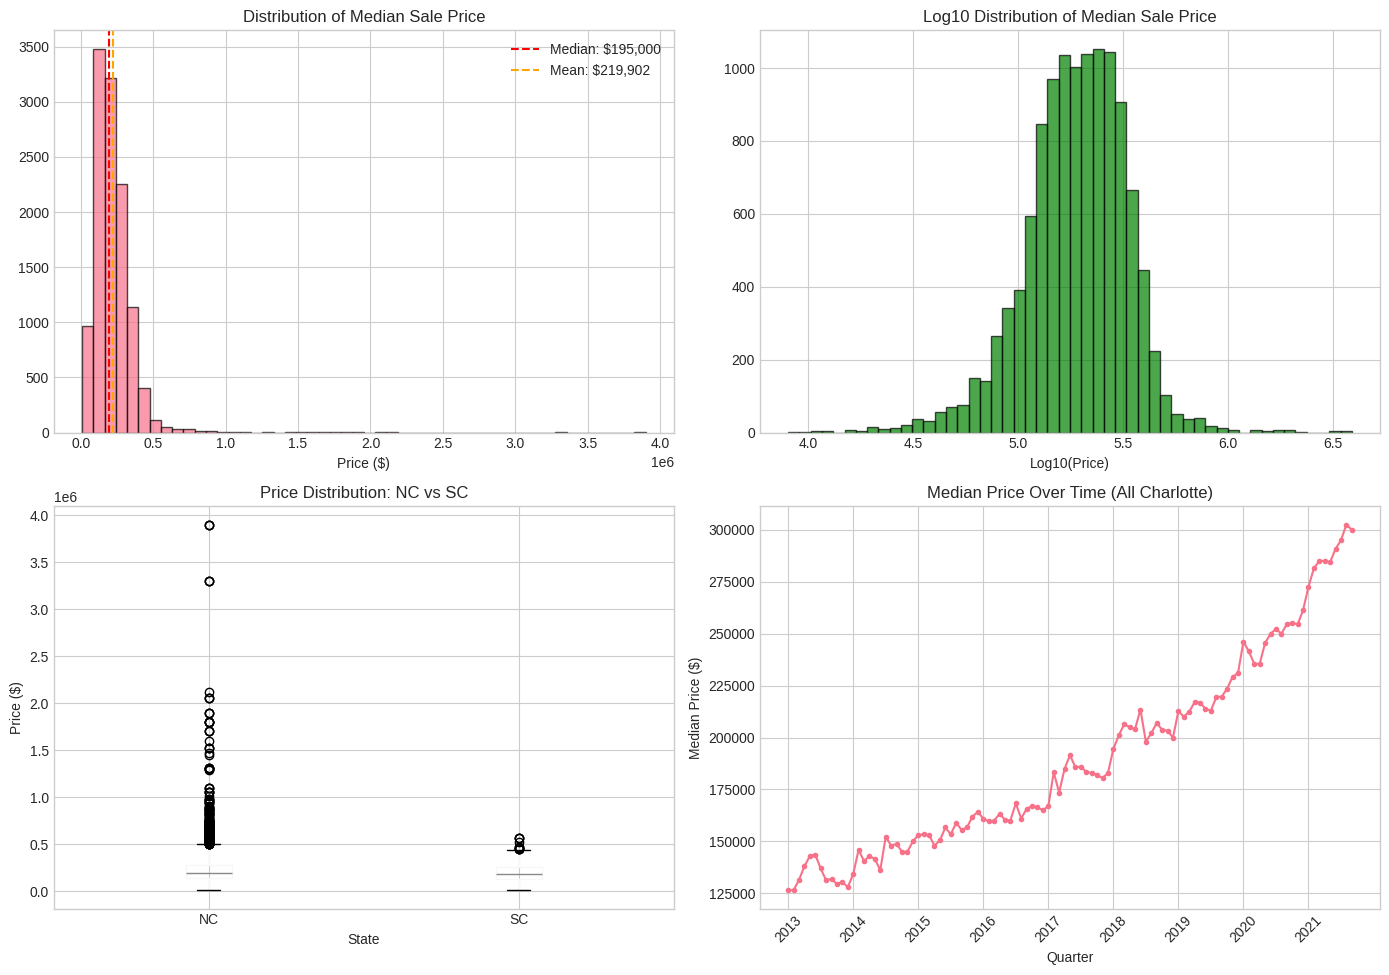


Target Variable Summary:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ value         │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 11765.0       │
│ null_count ┆ 0.0           │
│ mean       ┆ 219902.398768 │
│ std        ┆ 155121.046768 │
│ min        ┆ 8000.0        │
│ 25%        ┆ 135000.0      │
│ 50%        ┆ 195000.0      │
│ 75%        ┆ 275050.0      │
│ max        ┆ 3.9e6         │
└────────────┴───────────────┘


In [28]:
# ============================================================
# TARGET VARIABLE ANALYSIS - median_sale_price
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1.1 Distribution
axes[0,0].hist(df_pd['median_sale_price'], bins=50, edgecolor='black', alpha=0.7)
axes[0,0].axvline(df_pd['median_sale_price'].median(), color='red', linestyle='--', 
                   label=f"Median: ${df_pd['median_sale_price'].median():,.0f}")
axes[0,0].axvline(df_pd['median_sale_price'].mean(), color='orange', linestyle='--',
                   label=f"Mean: ${df_pd['median_sale_price'].mean():,.0f}")
axes[0,0].set_title('Distribution of Median Sale Price')
axes[0,0].set_xlabel('Price ($)')
axes[0,0].legend()

# 1.2 Log distribution
axes[0,1].hist(np.log10(df_pd['median_sale_price']), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0,1].set_title('Log10 Distribution of Median Sale Price')
axes[0,1].set_xlabel('Log10(Price)')

# 1.3 Box plot by state
df_pd.boxplot(column='median_sale_price', by='state_code', ax=axes[1,0])
axes[1,0].set_title('Price Distribution: NC vs SC')
axes[1,0].set_ylabel('Price ($)')
axes[1,0].set_xlabel('State')
plt.suptitle('')

# 1.4 Price over time
time_trend = df_pd.groupby('period_begin')['median_sale_price'].median().reset_index()
axes[1,1].plot(range(len(time_trend)), time_trend['median_sale_price'], marker='o', markersize=3)
axes[1,1].set_title('Median Price Over Time (All Charlotte)')
axes[1,1].set_xlabel('Quarter')
axes[1,1].set_ylabel('Median Price ($)')
# Add year labels
year_positions = [i for i, date in enumerate(time_trend['period_begin']) if date.endswith('02-01')]
year_labels = [date[:4] for date in time_trend['period_begin'] if date.endswith('02-01')]
axes[1,1].set_xticks(year_positions)
axes[1,1].set_xticklabels(year_labels, rotation=45)

plt.tight_layout()
plt.show()

# Summary stats
print("\nTarget Variable Summary:")
print(df['median_sale_price'].describe())

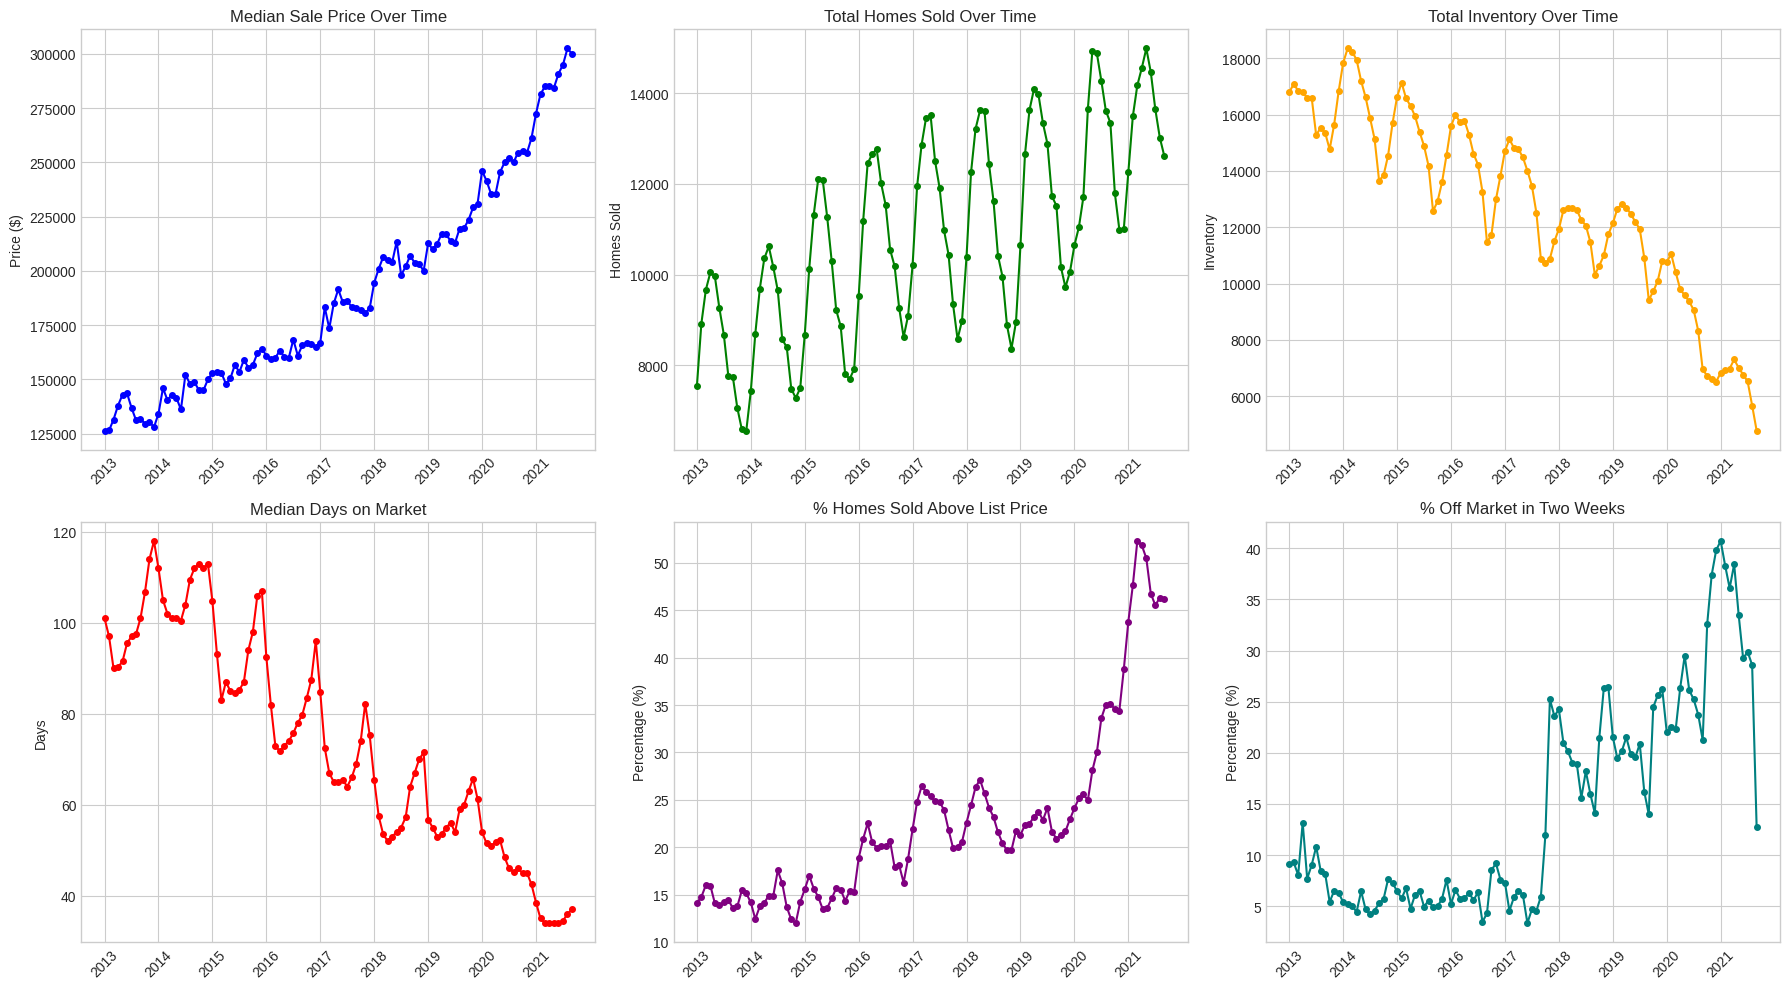

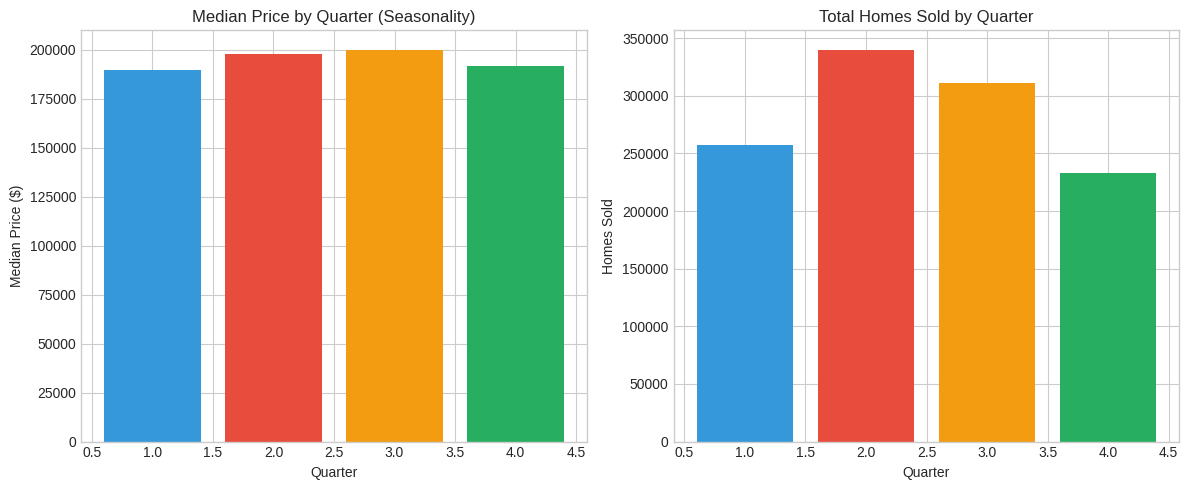


📊 SEASONALITY INSIGHTS:
  Highest price quarter: 3 ($200,000)
  Lowest price quarter:  1 ($189,900)
  Highest volume quarter: 2 (339,754 homes)
  Lowest volume quarter:  4 (232,650 homes)


In [29]:
# ============================================================
# CATEGORY 2: TEMPORAL ANALYSIS
# ============================================================

# Aggregate by quarter
quarterly = df_pd.groupby('period_begin').agg({
    'median_sale_price': 'median',
    'homes_sold': 'sum',
    'inventory': 'sum',
    'median_dom': 'median',
    'sold_above_list': 'mean',
    'off_market_in_two_weeks': 'mean'
}).reset_index()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 2.1 Price trend
axes[0,0].plot(range(len(quarterly)), quarterly['median_sale_price'], marker='o', markersize=4, color='blue')
axes[0,0].set_title('Median Sale Price Over Time')
axes[0,0].set_ylabel('Price ($)')
axes[0,0].set_xticks(year_positions)
axes[0,0].set_xticklabels(year_labels, rotation=45)

# 2.2 Volume trend
axes[0,1].plot(range(len(quarterly)), quarterly['homes_sold'], marker='o', markersize=4, color='green')
axes[0,1].set_title('Total Homes Sold Over Time')
axes[0,1].set_ylabel('Homes Sold')
axes[0,1].set_xticks(year_positions)
axes[0,1].set_xticklabels(year_labels, rotation=45)

# 2.3 Inventory trend
axes[0,2].plot(range(len(quarterly)), quarterly['inventory'], marker='o', markersize=4, color='orange')
axes[0,2].set_title('Total Inventory Over Time')
axes[0,2].set_ylabel('Inventory')
axes[0,2].set_xticks(year_positions)
axes[0,2].set_xticklabels(year_labels, rotation=45)

# 2.4 Days on market
axes[1,0].plot(range(len(quarterly)), quarterly['median_dom'], marker='o', markersize=4, color='red')
axes[1,0].set_title('Median Days on Market')
axes[1,0].set_ylabel('Days')
axes[1,0].set_xticks(year_positions)
axes[1,0].set_xticklabels(year_labels, rotation=45)

# 2.5 % Sold above list
axes[1,1].plot(range(len(quarterly)), quarterly['sold_above_list']*100, marker='o', markersize=4, color='purple')
axes[1,1].set_title('% Homes Sold Above List Price')
axes[1,1].set_ylabel('Percentage (%)')
axes[1,1].set_xticks(year_positions)
axes[1,1].set_xticklabels(year_labels, rotation=45)

# 2.6 Quick sales
axes[1,2].plot(range(len(quarterly)), quarterly['off_market_in_two_weeks']*100, marker='o', markersize=4, color='teal')
axes[1,2].set_title('% Off Market in Two Weeks')
axes[1,2].set_ylabel('Percentage (%)')
axes[1,2].set_xticks(year_positions)
axes[1,2].set_xticklabels(year_labels, rotation=45)

plt.tight_layout()
plt.savefig('eda_02_temporal_trends.png', dpi=150)
plt.show()

# SEASONALITY
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

seasonal_price = df_pd.groupby('quarter')['median_sale_price'].median()
seasonal_volume = df_pd.groupby('quarter')['homes_sold'].sum()

axes[0].bar(seasonal_price.index, seasonal_price.values, color=['#3498db', '#e74c3c', '#f39c12', '#27ae60'])
axes[0].set_title('Median Price by Quarter (Seasonality)')
axes[0].set_ylabel('Median Price ($)')
axes[0].set_xlabel('Quarter')

axes[1].bar(seasonal_volume.index, seasonal_volume.values, color=['#3498db', '#e74c3c', '#f39c12', '#27ae60'])
axes[1].set_title('Total Homes Sold by Quarter')
axes[1].set_ylabel('Homes Sold')
axes[1].set_xlabel('Quarter')

plt.tight_layout()
plt.savefig('eda_02b_seasonality.png', dpi=150)
plt.show()

print(f"\n📊 SEASONALITY INSIGHTS:")
print(f"  Highest price quarter: {seasonal_price.idxmax()} (${seasonal_price.max():,.0f})")
print(f"  Lowest price quarter:  {seasonal_price.idxmin()} (${seasonal_price.min():,.0f})")
print(f"  Highest volume quarter: {seasonal_volume.idxmax()} ({seasonal_volume.max():,} homes)")
print(f"  Lowest volume quarter:  {seasonal_volume.idxmin()} ({seasonal_volume.min():,} homes)")


In [35]:
# Extract all rows where period begin year and period end year are different
df_anomalies = df.filter(
    pl.col('period_begin').str.slice(0, 4) != pl.col('period_end').str.slice(0, 4)
)
print(f"\nAnomalies found (period begin year != period end year): {len(df_anomalies)} rows")
print(df_anomalies)


Anomalies found (period begin year != period end year): 1774 rows
shape: (1_774, 25)
┌────────────┬────────────┬────────┬────────────┬───┬────────────┬───────────┬───────────┬─────────┐
│ period_beg ┆ period_end ┆ region ┆ state_code ┆ … ┆ median_dom ┆ new_listi ┆ new_listi ┆ quarter │
│ in         ┆ ---        ┆ ---    ┆ ---        ┆   ┆ _yoy       ┆ ngs_mom   ┆ ngs_yoy   ┆ ---     │
│ ---        ┆ str        ┆ i64    ┆ str        ┆   ┆ ---        ┆ ---       ┆ ---       ┆ i8      │
│ str        ┆            ┆        ┆            ┆   ┆ f64        ┆ f64       ┆ f64       ┆         │
╞════════════╪════════════╪════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═════════╡
│ 2013-11-01 ┆ 2014-01-31 ┆ 27013  ┆ NC         ┆ … ┆ 0.0        ┆ 0.166667  ┆ 0.0       ┆ 4       │
│ 2013-12-01 ┆ 2014-02-28 ┆ 27013  ┆ NC         ┆ … ┆ 0.0        ┆ -0.142857 ┆ 0.0       ┆ 4       │
│ 2014-11-01 ┆ 2015-01-31 ┆ 27013  ┆ NC         ┆ … ┆ 20.5       ┆ -0.428571 ┆ -0.428571 ┆ 4       │
│ 201

In [30]:
# ============================================================
# CATEGORY 3: GEOGRAPHIC ANALYSIS
# ============================================================

# Recent data (2020-2021)
recent = df_pd[df_pd['year'] >= 2020]

zip_stats = recent.groupby('region').agg({
    'median_sale_price': 'mean',
    'homes_sold': 'sum',
    'median_dom': 'mean',
    'sold_above_list': 'mean',
    'state_code': 'first'
}).round(2)
zip_stats.columns = ['avg_price', 'total_sold', 'avg_dom', 'pct_above_list', 'state']
zip_stats = zip_stats.sort_values('avg_price', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 15 most expensive
top_15 = zip_stats.head(15)
colors = ['#3498db' if s == 'NC' else '#e74c3c' for s in top_15['state']]
axes[0].barh(top_15.index, top_15['avg_price'], color=colors)
axes[0].set_title('Top 15 Most Expensive Zip Codes (2020-2021)')
axes[0].set_xlabel('Avg Price ($)')
axes[0].invert_yaxis()
# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', label='NC'), Patch(facecolor='#e74c3c', label='SC')]
axes[0].legend(handles=legend_elements)

# Top 15 by volume
by_volume = zip_stats.sort_values('total_sold', ascending=False).head(15)
colors = ['#3498db' if s == 'NC' else '#e74c3c' for s in by_volume['state']]
axes[1].barh(by_volume.index, by_volume['total_sold'], color=colors)
axes[1].set_title('Top 15 Zip Codes by Sales Volume (2020-2021)')
axes[1].set_xlabel('Total Homes Sold')
axes[1].invert_yaxis()
axes[1].legend(handles=legend_elements)

plt.tight_layout()
plt.savefig('eda_03_geographic.png', dpi=150)
plt.show()

# NC vs SC comparison
print("\n📍 NC vs SC COMPARISON (2020-2021):")
state_comp = recent.groupby('state_code').agg({
    'median_sale_price': 'mean',
    'homes_sold': 'sum',
    'median_dom': 'mean',
    'region': 'nunique'
}).round(2)
state_comp.columns = ['avg_price', 'total_sold', 'avg_dom', 'num_zips']
print(state_comp)

print("\n🏆 TOP 5 MOST EXPENSIVE ZIP CODES:")
print(zip_stats.head(5)[['avg_price', 'total_sold', 'avg_dom', 'state']])

print("\n🔥 TOP 5 HOTTEST MARKETS (fastest sales):")
hottest = zip_stats.sort_values('avg_dom').head(5)
print(hottest[['avg_price', 'total_sold', 'avg_dom', 'state']])

KeyError: 'year'